# 第15章 自然语言处理：应用

## 15.1 情感分析及数据集

### 练习15.1.1

我们可以修改本节中的哪些超参数来加速训练情感分析模型？

**解答：**

### 练习15.1.2

请实现一个函数来将[Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)的数据集加载到数据迭代器中进行情感分析。

**解答：**

## 15.2 情感分析：使用循环神经网络

### 练习15.2.1

增加迭代轮数可以提高训练和测试的准确性吗？调优其他超参数怎么样？

**解答：**

### 练习15.2.2

使用较大的预训练词向量，例如300维的GloVe嵌入。它是否提高了分类精度？

**解答：**

### 练习15.2.3

&emsp;&emsp;是否可以通过spaCy词元化来提高分类精度？需要安装Spacy（`pip install spacy`）和英语语言包（`python -m spacy download en`）。在代码中，首先导入Spacy（`import spacy`）。然后，加载Spacy英语软件包（`spacy_en = spacy.load('en')`）。最后，定义函数`def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]`并替换原来的`tokenizer`函数。请注意GloVe和spaCy中短语标记的不同形式。例如，短语标记“new york”在GloVe中的形式是“new-york”，而在spaCy词元化之后的形式是“new york”。

**解答：**

## 15.3 情感分析：使用卷积神经网络

### 练习15.3.1

调整超参数，并比较15.2节中用于情感分析的架构和本节中用于情感分析的架构，例如在分类精度和计算效率方面。

- 在分类精度方面，对于相同的epoch，本节使用的卷积神经网络测试精度好于15.2节中所用的循环神经网络；
- 在计算效率方面，对于相同的epoch，本节使用的卷积神经网络的训练速度快于15.2节中用的循环神经网络。

| 架构 | learning rate (default) | epoch | loss | train acc | test acc |
|:--:|:--:|:--:|:--:|:--:|:--:|
| RNN |0.01  | 5  |  | 87.6% | 85.4% |
| CNN |0.001 | 5  |  | 97.9% | 87.1% |
| RNN |0.01  | 10 |  | 92.8% | 84.5% |
| CNN |0.001 | 10 |  | 99.7% | 86.5% |
| RNN |0.01  | 20 |  | 95.8% | 84.8% |
| CNN |0.001 | 20 |  | 99.6% | 85.4% |

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import math

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [3]:
# 定义模型，下面的类中实现textCNN模型。
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

loss 0.070, train acc 0.976, test acc 0.869
3615.3 examples/sec on [device(type='cuda', index=0)]


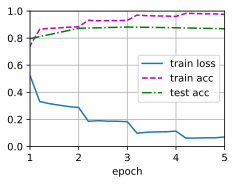

In [4]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.007, train acc 0.998, test acc 0.865
3983.4 examples/sec on [device(type='cuda', index=0)]


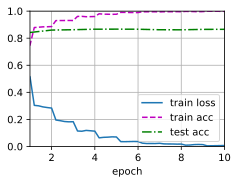

In [5]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.001, train acc 1.000, test acc 0.859
3965.4 examples/sec on [device(type='cuda', index=0)]


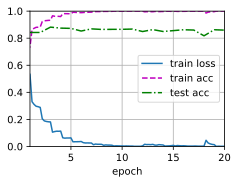

In [6]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

**解答：**

### 练习15.3.2

请试着用15.2节练习中介绍的方法进一步提高模型的分类精度。

**解答：**

### 练习15.3.3        

在输入表示中添加位置编码。它是否提高了分类的精度？

**解答：**

&emsp; &emsp; 在输入表示中添加位置编码，可以提高分类的精度，同时也降低了模型过拟合的程度。

-  关于位置编码的添加方式可参考这个 [transformer-note](https://github.com/WGS-note/transformer-note/blob/81a750f938ceb3c8d1ecb18ae6cf1aa0eff34124/transformer.py#L229)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import math

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

定义类实现位置编码，参考[10.6自注意力与位置编码](https://zh.d2l.ai/chapter_attention-mechanisms/self-attention-and-positional-encoding.html)，之后在textCNN模型中添加位置编码到词嵌入向量。

In [7]:
# 下面的类实现位置编码
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout=0, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

    

# 定义模型，下面的类中实现textCNN模型。
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):        
        embeddings = self.embedding(inputs)
        # 添加位置编码到词嵌入向量中
#         embeddings = self.positional_encoding(embeddings.transpose(0, 1)).transpose(0, 1)  
        embeddings = self.positional_encoding(embeddings)
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            embeddings, self.constant_embedding(inputs)), dim=2)  
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

loss 0.127, train acc 0.955, test acc 0.876
3894.1 examples/sec on [device(type='cuda', index=0)]


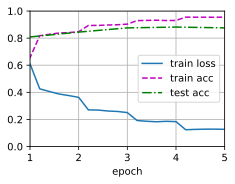

In [8]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 15.4 自然语言推断与数据集

### 练习15.4.1

机器翻译长期以来一直是基于翻译输出和翻译真实值之间的表面$n$元语法匹配来进行评估的。可以设计一种用自然语言推断来评价机器翻译结果的方法吗？

**解答：**

&emsp;&emsp; 可以。随着自然语言处理技术的发展，自然语言推断已经成为了一种有效的评价机器翻译结果的方法。自然语言推断可以通过比较翻译输出和翻译真实值之间的逻辑关系来评估翻译质量。例如，可以使用逻辑推理技术来检测翻译输出是否与翻译真实值一致，或者是否存在逻辑矛盾或歧义。此外，还可以使用语义推理技术来比较翻译输出和翻译真实值之间的语义相似性。因此，自然语言推断可以为机器翻译的评估提供更加准确和全面的方法。

### 练习15.4.2

我们如何更改超参数以减小词表大小？

**解答：**

&emsp;&emsp; 1. 减小词向量维度：词向量的维度越高，词表大小也越大。通过减小词向量的维度，可以减小词表大小。

&emsp;&emsp; 2. 减小最小词频：在构建词表时，可以设置一个最小词频阈值，只有出现次数大于该阈值的词才会被加入词表。通过减小最小词频阈值，可以减小词表大小。

&emsp;&emsp; 3. 使用更高级的词向量模型：一些高级的词向量模型，如BERT、GPT等，可以通过预训练的方式得到更加优秀的词向量表示，从而减小词表大小。

&emsp;&emsp; 4. 使用更加精细的分词工具：一些分词工具，如jieba、ltp等，可以通过设置不同的分词模式，得到更加精细的分词结果，从而减小词表大小。

&emsp;&emsp; 5. 去除停用词：停用词是指在文本中出现频率较高，但对文本语义没有贡献的词语，如“的”、“是”、“在”等。通过去除停用词，可以减小词表大小。

## 15.5 自然语言推断：使用注意力

### 练习15.5.1

使用其他超参数组合训练模型，能在测试集上获得更高的准确度吗？

**解答：**

### 练习15.5.2

自然语言推断的可分解注意模型的主要缺点是什么？

**解答：**

### 练习15.5.3

假设我们想要获得任何一对句子的语义相似级别（例如，0～1之间的连续值）。我们应该如何收集和标注数据集？请尝试设计一个有注意力机制的模型。

**解答：**

## 15.6 针对序列级和词元级应用微调BERT

### 练习15.6.1

让我们为新闻文章设计一个搜索引擎算法。当系统接收到查询（例如，“冠状病毒爆发期间的石油行业”）时，它应该返回与该查询最相关的新闻文章的排序列表。假设我们有一个巨大的新闻文章池和大量的查询。为了简化问题，假设为每个查询标记了最相关的文章。如何在算法设计中应用负采样（见14.2.1节）和BERT？

**解答：**

### 练习15.6.2        

我们如何利用BERT来训练语言模型？

**解答：**

### 练习15.6.3

我们能在机器翻译中利用BERT吗？

**解答：**

## 15.7 自然语言推断：微调BERT

### 练习15.7.1

&emsp;&emsp;如果您的计算资源允许，请微调一个更大的预训练BERT模型，该模型与原始的BERT基础模型一样大。修改`load_pretrained_model`函数中的参数设置：将“bert.small”替换为“bert.base”，将`num_hiddens=256`、`ffn_num_hiddens=512`、`num_heads=4`和`num_layers=2`的值分别增加到768、3072、12和12。通过增加微调迭代轮数（可能还会调优其他超参数），你可以获得高于0.86的测试精度吗？

**解答：**

### 练习15.7.2

如何根据一对序列的长度比值截断它们？将此对截断方法与`SNLIBERTDataset`类中使用的方法进行比较。它们的利弊各是什么？

**解答：**